In [1]:
!pip install pandas
!pip install opendatasets

In [2]:
import opendatasets as od
import cv2
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import seaborn as sns
import io, os
import matplotlib.pyplot as plt
from keras.optimizers import Adam,SGD,RMSprop

# Importing Deep Learning Libraries

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, Concatenate,Lambda
from tensorflow.keras.utils import plot_model

from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Input, Concatenate
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train_dir = '../input/fer2013/train/'
test_dir = '../input/fer2013/test/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       surprise  fear  angry  neutral   sad  disgust  happy
train      3171  4097   3995     4965  4830      436   7215
      surprise  fear  angry  neutral   sad  disgust  happy
test       831  1024    958     1233  1247      111   1774


<Axes: >

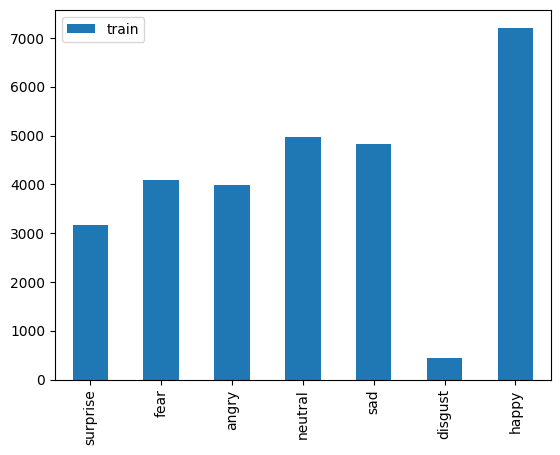

In [4]:
train_count.transpose().plot(kind='bar')

<Axes: >

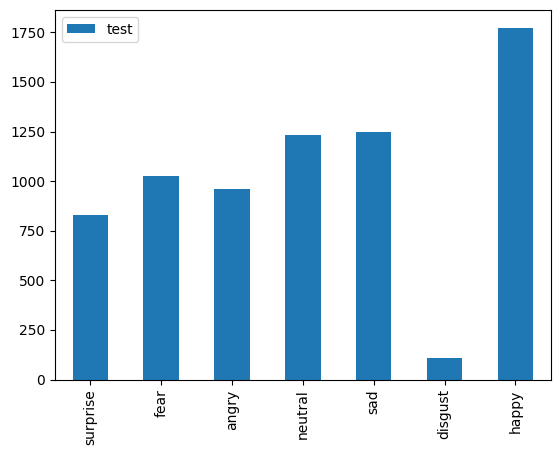

In [5]:
test_count.transpose().plot(kind='bar')

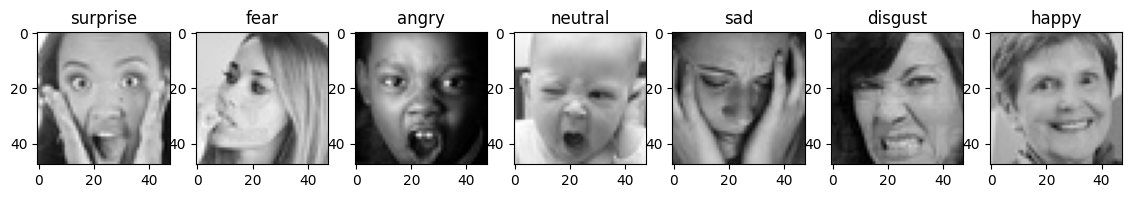

In [6]:
from keras.preprocessing.image import load_img
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[5]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('on')
    i += 1
plt.show()

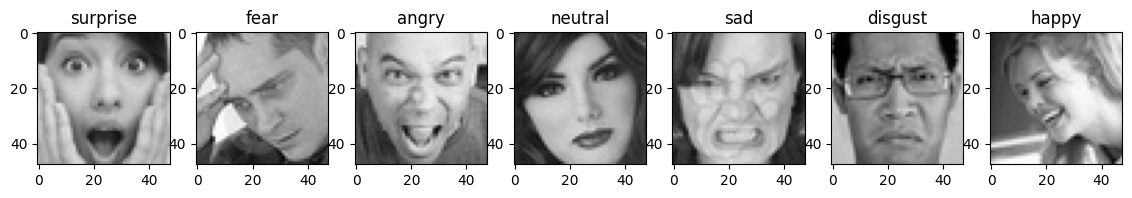

In [7]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(test_dir):
    img = load_img((test_dir + expression +'/'+ os.listdir(test_dir + expression)[5]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('on')
    i += 1
plt.show()

In [39]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from shutil import copyfile

# Define the function to augment all classes to a specified goal value
def augment_all_classes(train_path, goal_value, save_path):
    classes = os.listdir(train_path)

    for expression in classes:
        class_path = os.path.join(train_path, expression)

        # Count the current number of images in the class
        current_count = len(os.listdir(class_path))

        if current_count >= goal_value:
            print(f"No augmentation needed for the '{expression}' class.")
            continue

        # Calculate the number of images to be augmented
        to_be_augmented = goal_value - current_count
        print(f"'{expression}' class contains {current_count} images ===> to be augmented: {to_be_augmented}")

        # Load existing images in the class
        batches = ImageDataGenerator().flow_from_directory(directory=train_path,
                                                           target_size=(48, 48),
                                                           batch_size=current_count,
                                                           classes=[expression],
                                                           color_mode='grayscale')
        imgs, labels = next(batches)

        X_train = imgs / 255.
        y_train = labels

        # Generate augmented data and save them in the new directory
        fname_aug = os.path.join(save_path, expression)

        # Create the directory if it does not exist
        os.makedirs(fname_aug, exist_ok=True)

        # Number of images to be added to_be_augmented OR an integer
        aug_size = int(to_be_augmented * 0.25)

        # Method 1: feature standardization
        datagen_fs = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
        datagen_fs.fit(X_train)
        for X_batch, y_batch in datagen_fs.flow(X_train, y_train, batch_size=aug_size, save_to_dir=fname_aug,
                                                save_prefix='aug_fs_', save_format='png'):
            break

        # Method 2: Random Rotation
        datagen_rot = ImageDataGenerator(rotation_range=10)
        datagen_rot.fit(X_train)
        for X_batch, y_batch in datagen_rot.flow(X_train, y_train, batch_size=aug_size, save_to_dir=fname_aug,
                                                 save_prefix='aug_rot_', save_format='png'):
            break

        # Method 3: Random shifts
        shift = 0.1
        datagen_shifts = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)
        datagen_shifts.fit(X_train)
        for X_batch, y_batch in datagen_shifts.flow(X_train, y_train, batch_size=aug_size, save_to_dir=fname_aug,
                                                    save_prefix='aug_shift_', save_format='png'):
            break

        # Method 4: Random flips
        datagen_flips = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
        datagen_flips.fit(X_train)
        for X_batch, y_batch in datagen_flips.flow(X_train, y_train, batch_size=aug_size, save_to_dir=fname_aug,
                                                   save_prefix='aug_flips_', save_format='png'):
            break

# Path to the train part of the dataset
train_dir = '/kaggle/input/fer2013/train/'
test_dir = '/kaggle/input/fer2013/test/'

# New directory to save augmented images
augmented_dir = '/kaggle/working/augmented_dataset/'
os.makedirs(augmented_dir, exist_ok=True)

# Set the goal value for all classes
all_classes_goal_value = 7000

# Call the function to augment all classes
augment_all_classes(train_dir, all_classes_goal_value, augmented_dir)

# Combine original and augmented datasets
combined_dir = '/kaggle/working/combined_dataset/'
os.makedirs(combined_dir, exist_ok=True)

# Copy original images to the combined directory
for expression in os.listdir(train_dir):
    original_class_path = os.path.join(train_dir, expression)
    combined_class_path = os.path.join(combined_dir, expression)
    os.makedirs(combined_class_path, exist_ok=True)

    for img_name in os.listdir(original_class_path):
        img_path = os.path.join(original_class_path, img_name)
        copyfile(img_path, os.path.join(combined_class_path, img_name))

# Copy augmented images to the combined directory
for expression in os.listdir(augmented_dir):
    augmented_class_path = os.path.join(augmented_dir, expression)
    combined_class_path = os.path.join(combined_dir, expression)
    os.makedirs(combined_class_path, exist_ok=True)

    for img_name in os.listdir(augmented_class_path):
        img_path = os.path.join(augmented_class_path, img_name)
        copyfile(img_path, os.path.join(combined_class_path, img_name))

# Define callbacks for training
checkpointer = [EarlyStopping(monitor='val_accuracy', verbose=1, restore_best_weights=True, mode="max", patience=10),
                ModelCheckpoint(
                    filepath='model3.weights.best.hdf5',
                    monitor="val_accuracy",
                    verbose=1,
                    save_best_only=True,
                    mode="max")]

# Update ImageDataGenerator for training to include the path to the combined dataset
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   validation_split=0.2,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   vertical_flip=True,
                                   fill_mode='nearest')

# Update the directory to include the combined images
training_set = train_datagen.flow_from_directory(
    combined_dir,  # Path to the combined dataset
    batch_size=64,
    target_size=(48, 48),
    shuffle=True,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training'
)

validation_set = train_datagen.flow_from_directory(combined_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical',
                                                subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                color_mode='grayscale',
                                                class_mode='categorical')


'surprise' class contains 3171 images ===> to be augmented: 3829
Found 3171 images belonging to 1 classes.
'fear' class contains 4097 images ===> to be augmented: 2903
Found 4097 images belonging to 1 classes.
'angry' class contains 3995 images ===> to be augmented: 3005
Found 3995 images belonging to 1 classes.
'neutral' class contains 4965 images ===> to be augmented: 2035
Found 4965 images belonging to 1 classes.
'sad' class contains 4830 images ===> to be augmented: 2170
Found 4830 images belonging to 1 classes.
'disgust' class contains 436 images ===> to be augmented: 6564
Found 436 images belonging to 1 classes.
No augmentation needed for the 'happy' class.
Found 60592 images belonging to 7 classes.
Found 15144 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [45]:
# Remove the 'virtual_documents' key from class indices
training_set.class_indices.pop('.virtual_documents', None)
import os
import pandas as pd

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = os.path.join(path, expression)
        if os.path.isdir(dir_):  # Check if it's a directory
            dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df

# Example usage:
train_count = count_exp(combined_dir, 'train')
print(train_count)


       surprise    sad  angry   fear  neutral  happy  disgust
train     14654  11334  13007  12797    11061   7215     5668


In [46]:
import tensorflow as tf
import keras
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
model= tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(512,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer = Adam(lr=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

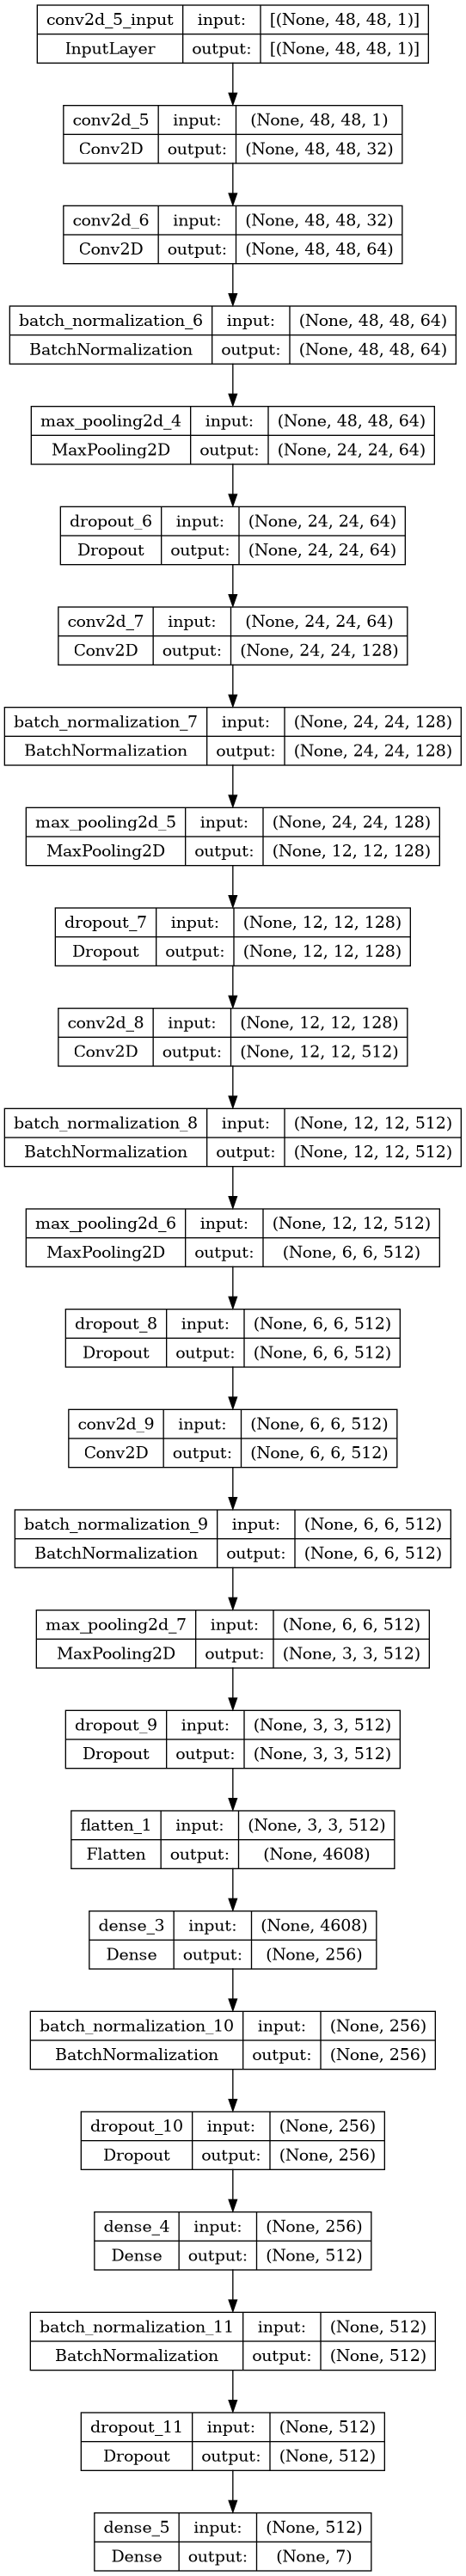

In [47]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [48]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, restore_best_weights=True,mode="max",patience = 10),
                ModelCheckpoint(
                    filepath='model3.weights.best.hdf5',
                    monitor="val_accuracy",
                    verbose=1,
                    save_best_only=True,
                    mode="max")]

steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = validation_set.n // validation_set.batch_size

history = model.fit(x=training_set,
                 validation_data=validation_set,
                 epochs=100,
                 callbacks=[checkpointer],
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/100


2023-12-02 22:16:22.597290: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


946/946 [==============================] - ETA: 0s - loss: 2.0194 - accuracy: 0.2224
Epoch 1: val_accuracy improved from -inf to 0.13857, saving model to model3.weights.best.hdf5
946/946 [==============================] - 67s 66ms/step - loss: 2.0194 - accuracy: 0.2224 - val_loss: 2.6128 - val_accuracy: 0.1386
Epoch 2/100


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


946/946 [==============================] - ETA: 0s - loss: 1.7026 - accuracy: 0.3257
Epoch 2: val_accuracy improved from 0.13857 to 0.34017, saving model to model3.weights.best.hdf5
946/946 [==============================] - 62s 65ms/step - loss: 1.7026 - accuracy: 0.3257 - val_loss: 1.6984 - val_accuracy: 0.3402
Epoch 3/100
946/946 [==============================] - ETA: 0s - loss: 1.5157 - accuracy: 0.4056
Epoch 3: val_accuracy improved from 0.34017 to 0.43280, saving model to model3.weights.best.hdf5
946/946 [==============================] - 61s 64ms/step - loss: 1.5157 - accuracy: 0.4056 - val_loss: 1.4507 - val_accuracy: 0.4328
Epoch 4/100
946/946 [==============================] - ETA: 0s - loss: 1.4098 - accuracy: 0.4523
Epoch 4: val_accuracy improved from 0.43280 to 0.46981, saving model to model3.weights.best.hdf5
946/946 [==============================] - 61s 65ms/step - loss: 1.4098 - accuracy: 0.4523 - val_loss: 1.3655 - val_accuracy: 0.4698
Epoch 5/100
946/946 [==========

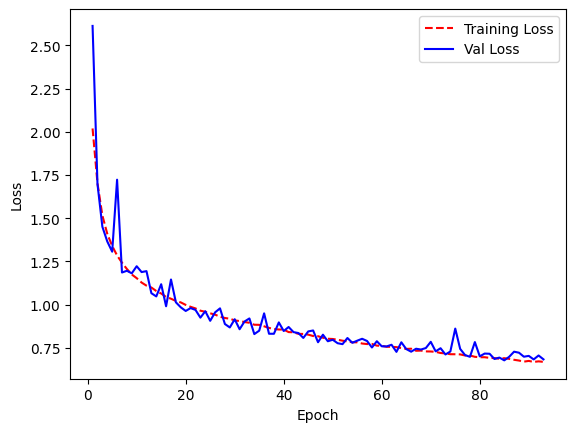

In [49]:
training_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.rcParams['figure.figsize'] = [10, 5]
plt.style.use(['default'])
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [50]:
model.save("fer_model.h5")


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [51]:
accuracy = model.evaluate(test_set)[1]

print(f"Accuracy: {accuracy * 100:.2f}%")

113/113 [==============================] - 12s 107ms/step - loss: 0.9665 - accuracy: 0.6686
Accuracy: 66.86%


In [52]:
print(f"Test accuracy = {model.evaluate(test_set ,batch_size=test_set.batch_size,steps=test_set.n // test_set.batch_size)[1]*100}%")

112/112 [==============================] - 6s 53ms/step - loss: 0.9666 - accuracy: 0.6685
Test accuracy = 66.85267686843872%


In [ ]:
y_pred = model.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

In [ ]:
y_pred = model.predict(validation_set)
y_pred = np.argmax(y_pred, axis=1)
cm_val = confusion_matrix(validation_set.classes, y_pred)
print('Confusion Matrix')
print(cm_val)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

In [ ]:
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)

cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

In [57]:
# next function assigns one batch to variables, i.e x_test,y_test will have 64 images
x_test,y_test = next(test_set)
predict = model.predict(x_test)

2/2 [==============================] - 0s 6ms/step


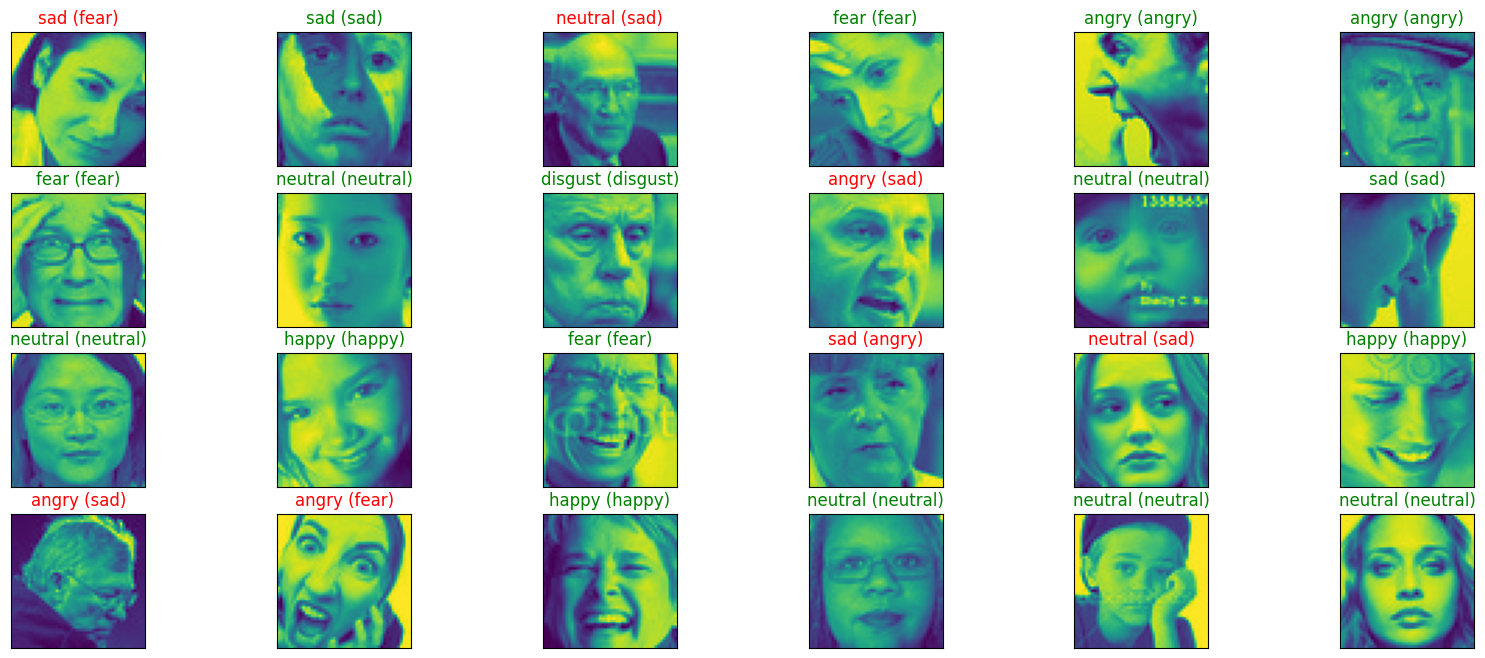

In [58]:
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = class_labels[(np.argmax(predict[index]))]
    true_index = class_labels[(np.argmax(y_test[index]))]

    ax.set_title("{} ({})".format((predict_index),
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))